# 有效静力稳定度 (Effective Static Stability) 详解

## 物理意义

根据 O'Gorman (2011, JAS) 的理论，有效静力稳定度描述了**大气对湿对流的响应能力**。

### 三个关键概念：

1. **干静力稳定度** $\frac{d\theta}{dp}$: 
   - 描述干空气的稳定程度
   - 值越大，大气越稳定，越难发生对流

2. **湿静力稳定度** $\frac{d\theta_m}{dp}$:
   - 沿湿绝热线的位温梯度
   - 考虑了水汽凝结释放潜热的影响
   - 通常比干稳定度小（因为潜热释放减弱了稳定性）

3. **有效静力稳定度** $\frac{d\theta_{eff}}{dp}$:
   - $\frac{d\theta_{eff}}{dp} = \frac{d\theta}{dp} - \lambda \frac{d\theta_m}{dp}$
   - $\lambda$ 是非对称参数（通常0.6），描述上升与下沉运动的非对称性
   - 反映了**实际大气中湿对流对稳定度的有效减弱**

### 为什么需要有效稳定度？

在有湿对流的大气中：
- **上升气流**：饱和，沿湿绝热上升，稳定度较弱
- **下沉气流**：通常不饱和，沿干绝热下沉，稳定度较强
- 上升区域面积小但强度大，下沉区域面积大但强度弱
- **有效稳定度**综合考虑了这种非对称性

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec


In [54]:

def eff_stat_stab(p, temp, lambda_=0.6):
    """
    Calculate effective static stability following O'Gorman (2011, JAS, Eq. 8)

    Parameters
    ----------
    p : array_like
        Pressure (Pa)
    temp : array_like
        Temperature (K)
    lambda_ : float, optional
        Asymmetry parameter (default 0.6)

    Returns
    -------
    dtheta_dp_eff : ndarray
        Effective static stability (dθ_eff/dp)
    """

    # Constants
    Rd = 287.04      # J/kg/K
    Rv = 461.5       # J/kg/K
    cpd = 1005.7     # J/kg/K
    cpv = 1870.0     # J/kg/K
    g = 9.80665      # m/s^2
    p0 = 1e5         # Pa
    kappa = Rd / cpd
    gc_ratio = Rd / Rv

    # Saturation vapor pressure (Bolton, 1980)
    Tc = temp - 273.15
    es = 611.20 * np.exp(17.67 * Tc / (Tc + 243.5))  # Pa

    # Latent heat of condensation
    L = (2.501 - 0.00237 * Tc) * 1e6  # J/kg

    # Saturation mixing ratio
    rs = gc_ratio * es / (p - es)
    # saturation specific humidity
    qs = rs / (1 + rs)

    # Potential temperature
    exponent = kappa * (1 + rs / gc_ratio) / (1 + rs * cpv / cpd)
    theta = temp * (p0 / p) ** exponent

    # Derivative of θ wrt p
    dtheta_dp = np.gradient(theta, p)

    # Virtual temperature and density
    temp_virtual = temp * (1.0 + rs / gc_ratio) / (1.0 + rs)
    rho = p / (Rd * temp_virtual)

    # Moist adiabatic lapse rate
    malr = (g / cpd) * (1 + rs) / (1 + (cpv / cpd) * rs) \
           * (1 + (L * rs) / (Rd * temp)) \
           / (1 + (L ** 2 * rs * (1 + rs / gc_ratio)) / (Rv * temp ** 2 * (cpd + rs * cpv)))

    # Moist-adiabatic dθ/dp (approximation)
    dtemp_dp_ma = malr / g / rho
    dtheta_dp_ma = dtemp_dp_ma * theta / temp - exponent * theta / p

    # Effective static stability
    dtheta_dp_eff = dtheta_dp - lambda_ * dtheta_dp_ma

    return dtheta_dp, dtheta_dp_ma, dtheta_dp_eff


In [55]:

def eff_stat_stab_components(p, temp, lambda_=0.6):
    """
    计算干、湿、有效静力稳定度 (O'Gorman 2011)
    
    返回:
    - dθ/dp: 干静力稳定度
    - dθm/dp: 湿静力稳定度（沿湿绝热）
    - dθeff/dp: 有效静力稳定度
    """
    Rd = 287.04
    Rv = 461.5
    cpd = 1005.7
    cpv = 1870.0
    g = 9.80665
    p0 = 1e5
    kappa = Rd / cpd
    gc_ratio = Rd / Rv

    Tc = temp - 273.15
    es = 611.20 * np.exp(17.67 * Tc / (Tc + 243.5))
    L = (2.501 - 0.00237 * Tc) * 1e6
    rs = gc_ratio * es / (p - es)
    exponent = kappa * (1 + rs / gc_ratio) / (1 + rs * cpv / cpd)
    theta = temp * (p0 / p) ** exponent

    dtheta_dp = np.gradient(theta, p)

    temp_virtual = temp * (1.0 + rs / gc_ratio) / (1.0 + rs)
    rho = p / (Rd * temp_virtual)

    malr = (g / cpd) * (1 + rs) / (1 + (cpv / cpd) * rs) \
        * (1 + (L * rs) / (Rd * temp)) \
        / (1 + (L ** 2 * rs * (1 + rs / gc_ratio)) / (Rv * temp ** 2 * (cpd + rs * cpv)))

    dtemp_dp_ma = malr / g / rho
    dtheta_dp_ma = dtemp_dp_ma * theta / temp - exponent * theta / p

    dtheta_dp_eff = dtheta_dp - lambda_ * dtheta_dp_ma

    return dtheta_dp, dtheta_dp_ma, dtheta_dp_eff, theta, rs




### 1. 物理解释

- **干稳定度** $\frac{d\theta}{dp}$: 总是正值，表示大气层结稳定
- **湿稳定度** $\frac{d\theta_m}{dp}$: 比干稳定度小，因为上升气流中水汽凝结释放潜热
- **有效稳定度** $\frac{d\theta_{eff}}{dp}$: 介于二者之间，反映实际大气对对流的响应

### 2. 应用场景

**热带大气**（高温高湿）:
- 湿稳定度远小于干稳定度
- 有效稳定度显著降低
- 容易发生深对流

**中纬度大气**（温度适中）:
- 湿稳定度与干稳定度差异较小  
- 有效稳定度适中
- 对流活动适度

**干燥大气**:
- 湿稳定度接近干稳定度
- 有效稳定度与干稳定度相近
- 不易发生湿对流

### 3. 非对称参数 λ

$\lambda = 0.6$ 表示:
- 上升运动占总运动的约40%面积
- 下沉运动占约60%面积
- 但上升强度大于下沉强度
- 这是观测到的热带对流的典型特征


Tropical Atmospheric Stability Indices Comparison


/var/folders/8y/bhmcgdx11wz63c2wxqvp_pl00000gn/T/ipykernel_76791/2407140920.py:164: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


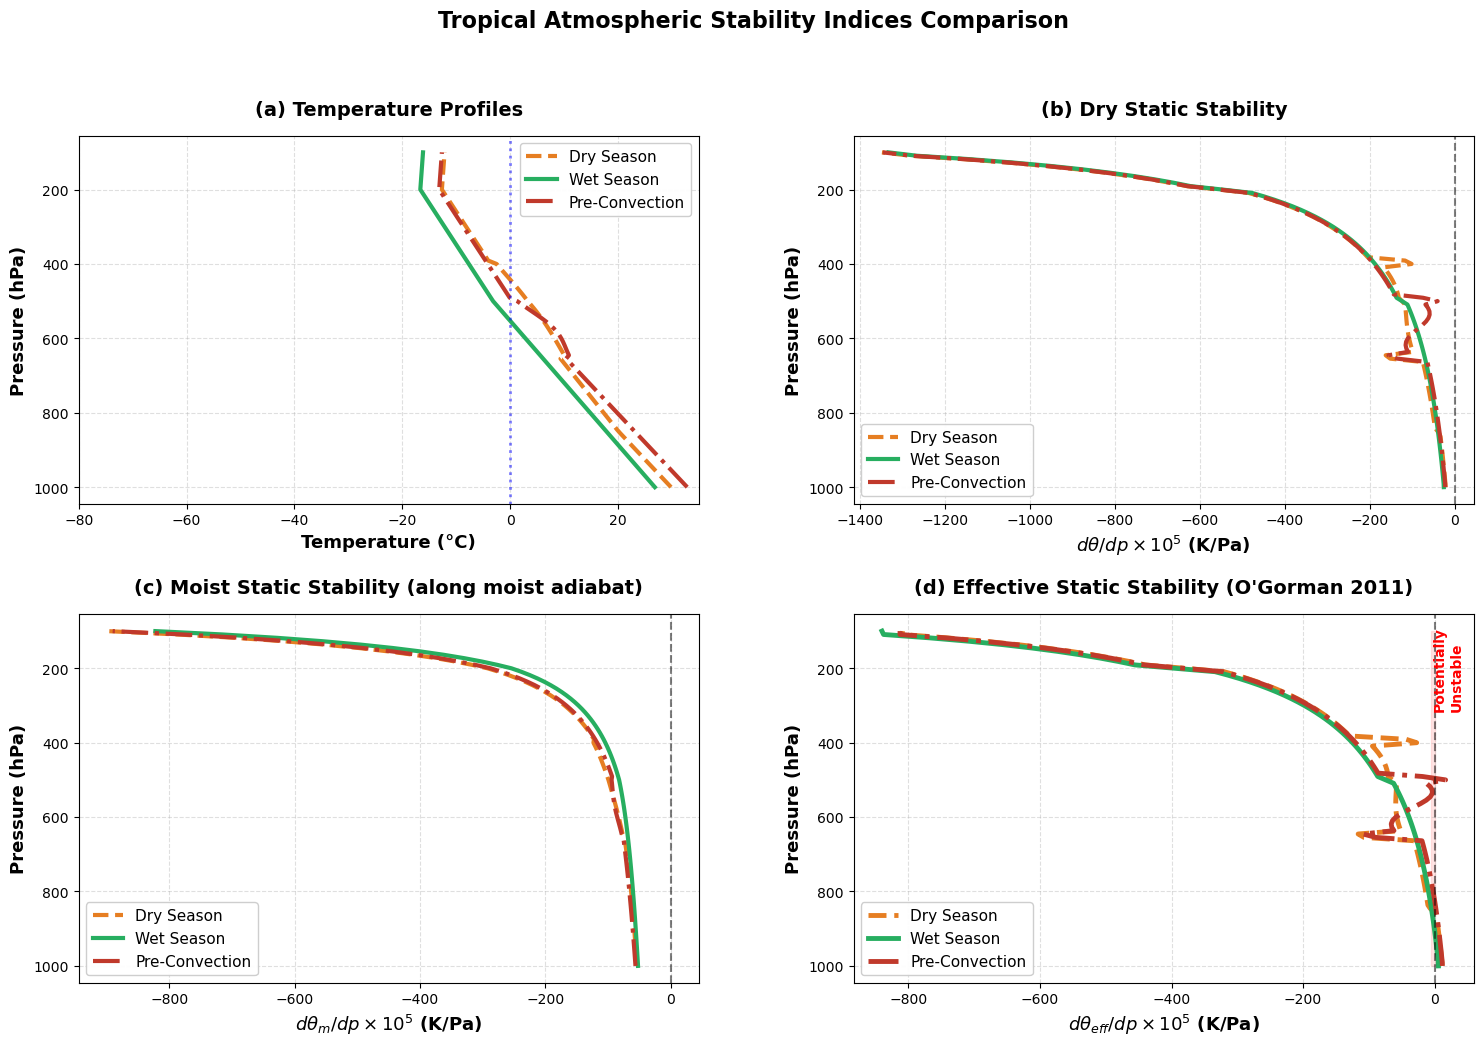


Quantitative Analysis (700-500 hPa Layer Mean)

【Dry Season】
  Dry Stability (dθ/dp):        -106.113 K/(100 Pa)
  Moist Stability (dθm/dp):     -83.307 K/(100 Pa)
  Effective Stability (dθeff/dp): -56.129 K/(100 Pa)
  Sat. Mixing Ratio at 700hPa:   12.58 g/kg
  Stability Reduction by Moist:   47.1%
  → Characteristics: Mid-level dry, moist stability ≈ dry stability
  → Convection: Suppressed, needs forced lifting

【Wet Season】
  Dry Stability (dθ/dp):        -84.710 K/(100 Pa)
  Moist Stability (dθm/dp):     -72.727 K/(100 Pa)
  Effective Stability (dθeff/dp): -41.074 K/(100 Pa)
  Sat. Mixing Ratio at 700hPa:   10.26 g/kg
  Stability Reduction by Moist:   51.5%
  → Characteristics: Moist atmosphere, moist stability << dry stability
  → Convection: Reduced effective stability, easily develops

【Pre-Convection】
  Dry Stability (dθ/dp):        -84.069 K/(100 Pa)
  Moist Stability (dθm/dp):     -84.071 K/(100 Pa)
  Effective Stability (dθeff/dp): -33.627 K/(100 Pa)
  Sat. Mixing Ratio at

In [56]:
# ========================================================================
# Tropical Atmospheric Stability Indices Comparison
# Scenarios: Dry Season vs Wet Season vs Pre-Convection Event
# ========================================================================

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Pressure range
p = np.linspace(100000, 10000, 100)  # Pa
p_hPa = p / 100

def create_tropical_profile(T_surface, lapse_low=6.5, lapse_mid=6.0, lapse_upper=4.5):
    """
    Create realistic tropical atmospheric temperature profile
    Based on typical tropical soundings (e.g., Singapore, Darwin)
    
    T_surface: Surface temperature (K)
    lapse_low: Lapse rate in boundary layer (K/km)
    lapse_mid: Lapse rate in mid-troposphere (K/km)
    lapse_upper: Lapse rate in upper troposphere (K/km)
    """
    temp = np.zeros_like(p)
    
    # Use piecewise polynomial fit for realistic tropical profile
    # Reference: Mean tropical sounding has ~100 hPa near tropopause
    for i, pressure in enumerate(p):
        p_mb = pressure / 100
        
        # Realistic tropical temperature profile
        if p_mb >= 850:
            # Boundary layer: nearly moist adiabatic
            temp[i] = T_surface - lapse_low * (1000 - p_mb) / 100
        elif p_mb >= 500:
            # Mid-troposphere: slightly stable
            T_850 = T_surface - lapse_low * (1000 - 850) / 100
            temp[i] = T_850 - lapse_mid * (850 - p_mb) / 100
        elif p_mb >= 200:
            # Upper troposphere: more stable
            T_850 = T_surface - lapse_low * (1000 - 850) / 100
            T_500 = T_850 - lapse_mid * (850 - 500) / 100
            temp[i] = T_500 - lapse_upper * (500 - p_mb) / 100
        else:
            # Tropopause region: isothermal/weak warming
            T_850 = T_surface - lapse_low * (1000 - 850) / 100
            T_500 = T_850 - lapse_mid * (850 - 500) / 100
            T_200 = T_500 - lapse_upper * (500 - 200) / 100
            # Weak warming above 200 hPa (lower stratosphere)
            temp[i] = T_200 + 0.5 * (200 - p_mb) / 100
    
    return temp


# ========================================================================
# Scenario 1: Dry Season Tropical Atmosphere (e.g., West African dry season)
# ========================================================================
print("="*80)
print("Tropical Atmospheric Stability Indices Comparison")
print("="*80)

# Scenario 1: Dry Season - Warm surface but subsiding dry air in mid-levels
# Characteristics: Strong subsidence → warmer mid-levels, steeper low-level lapse rate
temp_dry_season = create_tropical_profile(T_surface=303, lapse_low=6.5, lapse_mid=5.5, lapse_upper=4.5)
# Add subsidence warming at 600-400 hPa (representing SAL-like dry intrusion)
for i in range(len(p)):
    p_mb = p[i] / 100
    if 400 <= p_mb <= 650:  # 400-650 hPa layer
        # Gaussian-shaped warming centered at 500 hPa
        warming = 2.5 * np.exp(-((p_mb - 525)**2) / (2 * 100**2))
        temp_dry_season[i] += warming

# Scenario 2: Wet Season - Normal moist tropical atmosphere
# Characteristics: Near-moist-adiabatic throughout, cooler surface due to clouds/rain
temp_wet_season = create_tropical_profile(T_surface=300, lapse_low=6.0, lapse_mid=6.0, lapse_upper=4.5)

# Scenario 3: Pre-Convection - "Loaded Gun" sounding
# Characteristics: Very warm/moist surface + elevated inversion (CAP) + dry above
temp_severe_convection = create_tropical_profile(T_surface=306, lapse_low=6.5, lapse_mid=6.5, lapse_upper=4.5)
# Strong mid-level inversion (CAP) at 600-500 hPa
for i in range(len(p)):
    p_mb = p[i] / 100
    if 500 <= p_mb <= 650:  # Strong CAP layer
        # Sharp inversion to trap low-level moisture
        inversion_strength = 3.0 * np.exp(-((p_mb - 575)**2) / (2 * 50**2))
        temp_severe_convection[i] += inversion_strength

# Calculate stability for three scenarios
scenarios = [
    ("Dry Season", temp_dry_season, '#e67e22', '--'),
    ("Wet Season", temp_wet_season, '#27ae60', '-'),
    ("Pre-Convection", temp_severe_convection, '#c0392b', '-.'),
]

# ========================================================================
# Plotting: 4-panel comparison
# ========================================================================
fig = plt.figure(figsize=(18, 11))
gs = GridSpec(2, 2, figure=fig, hspace=0.3, wspace=0.25)

# ----- Panel 1: Temperature Profiles -----
ax1 = fig.add_subplot(gs[0, 0])
for name, temp, color, ls in scenarios:
    ax1.plot(temp - 273.15, p_hPa, label=name, color=color, lw=3, linestyle=ls)

ax1.invert_yaxis()
ax1.set_xlabel('Temperature (°C)', fontsize=13, fontweight='bold')
ax1.set_ylabel('Pressure (hPa)', fontsize=13, fontweight='bold')
ax1.set_title('(a) Temperature Profiles', fontsize=14, fontweight='bold', pad=15)
ax1.legend(fontsize=11, loc='upper right', framealpha=0.95)
ax1.grid(True, alpha=0.4, linestyle='--')
ax1.set_xlim(-80, 35)
ax1.axvline(0, color='blue', linestyle=':', alpha=0.5, linewidth=2)

# ----- Panel 2: Dry Static Stability -----
ax2 = fig.add_subplot(gs[0, 1])
for name, temp, color, ls in scenarios:
    dθ_dp, _, _, _, _ = eff_stat_stab_components(p, temp)
    ax2.plot(dθ_dp * 1e5, p_hPa, label=name, color=color, lw=3, linestyle=ls)

ax2.invert_yaxis()
ax2.axvline(0, color='k', linestyle='--', alpha=0.5, linewidth=1.5)
ax2.set_xlabel(r'$d\theta/dp \times 10^5$ (K/Pa)', fontsize=13, fontweight='bold')
ax2.set_ylabel('Pressure (hPa)', fontsize=13, fontweight='bold')
ax2.set_title('(b) Dry Static Stability', fontsize=14, fontweight='bold', pad=15)
ax2.legend(fontsize=11, loc='best', framealpha=0.95)
ax2.grid(True, alpha=0.4, linestyle='--')

# ----- Panel 3: Moist Static Stability -----
ax3 = fig.add_subplot(gs[1, 0])
for name, temp, color, ls in scenarios:
    _, dθm_dp, _, _, _ = eff_stat_stab_components(p, temp)
    ax3.plot(dθm_dp * 1e5, p_hPa, label=name, color=color, lw=3, linestyle=ls)

ax3.invert_yaxis()
ax3.axvline(0, color='k', linestyle='--', alpha=0.5, linewidth=1.5)
ax3.set_xlabel(r'$d\theta_m/dp \times 10^5$ (K/Pa)', fontsize=13, fontweight='bold')
ax3.set_ylabel('Pressure (hPa)', fontsize=13, fontweight='bold')
ax3.set_title('(c) Moist Static Stability (along moist adiabat)', fontsize=14, fontweight='bold', pad=15)
ax3.legend(fontsize=11, loc='best', framealpha=0.95)
ax3.grid(True, alpha=0.4, linestyle='--')

# ----- Panel 4: Effective Static Stability -----
ax4 = fig.add_subplot(gs[1, 1])
for name, temp, color, ls in scenarios:
    _, _, dθeff_dp, _, _ = eff_stat_stab_components(p, temp)
    ax4.plot(dθeff_dp * 1e5, p_hPa, label=name, color=color, lw=3.5, linestyle=ls)

ax4.invert_yaxis()
ax4.axvline(0, color='k', linestyle='--', alpha=0.5, linewidth=1.5)
ax4.set_xlabel(r'$d\theta_{eff}/dp \times 10^5$ (K/Pa)', fontsize=13, fontweight='bold')
ax4.set_ylabel('Pressure (hPa)', fontsize=13, fontweight='bold')
ax4.set_title('(d) Effective Static Stability (O\'Gorman 2011)', fontsize=14, fontweight='bold', pad=15)
ax4.legend(fontsize=11, loc='best', framealpha=0.95)
ax4.grid(True, alpha=0.4, linestyle='--')
# Mark unstable region
ax4.fill_betweenx([100, 1000], -5, 0, color='red', alpha=0.1, label='Unstable')
ax4.text(-2.5, 200, 'Potentially\nUnstable', fontsize=10, color='red', 
         rotation=90, va='center', fontweight='bold')

plt.suptitle('Tropical Atmospheric Stability Indices Comparison', 
             fontsize=16, fontweight='bold', y=0.995)

plt.tight_layout()
plt.show()


# ========================================================================
# Quantitative Analysis Results
# ========================================================================
print("\n" + "="*80)
print("Quantitative Analysis (700-500 hPa Layer Mean)")
print("="*80)

# Select 700-500 hPa layer (mid-troposphere, critical for convection)
idx_700 = np.argmin(np.abs(p_hPa - 700))
idx_500 = np.argmin(np.abs(p_hPa - 500))

for name, temp, color, ls in scenarios:
    dθ_dp, dθm_dp, dθeff_dp, _, rs = eff_stat_stab_components(p, temp)
    
    # CRITICAL FIX: Pressure array goes 1000→100 hPa, so idx increases with height
    # idx_700=33 (lower), idx_500=55 (higher), so slice is idx_700:idx_500+1
    dθ_mean = np.nanmean(dθ_dp[idx_700:idx_500+1]) * 1e5
    dθm_mean = np.nanmean(dθm_dp[idx_700:idx_500+1]) * 1e5
    dθeff_mean = np.nanmean(dθeff_dp[idx_700:idx_500+1]) * 1e5
    
    # Moisture
    rs_700 = rs[idx_700] * 1000  # g/kg
    
    # Stability reduction percentage
    reduction = (1 - dθeff_mean / dθ_mean) * 100
    
    print(f"\n【{name.replace(chr(10), ' ')}】")
    print(f"  Dry Stability (dθ/dp):        {dθ_mean:6.3f} K/(100 Pa)")
    print(f"  Moist Stability (dθm/dp):     {dθm_mean:6.3f} K/(100 Pa)")
    print(f"  Effective Stability (dθeff/dp): {dθeff_mean:6.3f} K/(100 Pa)")
    print(f"  Sat. Mixing Ratio at 700hPa:  {rs_700:6.2f} g/kg")
    print(f"  Stability Reduction by Moist:  {reduction:5.1f}%")
    
    # Physical interpretation
    if "Dry" in name:
        print(f"  → Characteristics: Mid-level dry, moist stability ≈ dry stability")
        print(f"  → Convection: Suppressed, needs forced lifting")
    elif "Wet" in name:
        print(f"  → Characteristics: Moist atmosphere, moist stability << dry stability")
        print(f"  → Convection: Reduced effective stability, easily develops")
    elif "Pre-Convection" in name:
        print(f"  → Characteristics: 'Loaded Gun' sounding, dry air in mid-levels")
        print(f"  → Convection: Explosive development once CAP is broken")


print("\n" + "="*80)
print("Key Findings")
print("="*80)
print("""
1. Dry Static Stability (dθ/dp):
   • Only depends on temperature stratification, ignores moisture
   • Similar across three scenarios
   • Cannot reflect convective potential

2. Moist Static Stability (dθm/dp):
   • Considers latent heat release from condensation
   • Significantly smaller than dry stability in moist atmosphere
   • Directly reflects stability of saturated ascending parcels

3. Effective Static Stability (dθeff/dp):
   • Accounts for updraft/downdraft asymmetry
   • Best reflects actual convective activity intensity
   • Negative values indicate potential instability

4. Implications for Tropical Convection Forecasting:
   ✓ Dry Season: Mid-level dry → Large effective stability → Convection suppressed
   ✓ Wet Season: Moist atmosphere → Reduced effective stability → Easy convection
   ✓ Pre-Convection: Low-level very moist + mid-level dry → High CAPE → Explosive development
""")

print("="*80)